In [1]:
from commons import *

In [2]:
# read in data
df = pd.read_csv("classifier_runtimes.csv")
df

,Unnamed: 0,openmlid,datapoints,trainpoints,testpoints,seed,classifier,traintime,testtime,exception
0,0,41066,1567,1,1566,0,bayesnet,1.0,2.0,NaN
1,1,41066,1567,1,1566,1,bayesnet,1.0,2.0,NaN
2,2,41066,1567,2,1565,0,bayesnet,1.0,2.0,NaN
3,3,41066,1567,2,1565,1,bayesnet,1.0,2.0,NaN
4,4,41066,1567,1,1566,2,bayesnet,1.0,86.0,NaN
...,...,...,...,...,...,...,...,...,...,...
761044,1688919,1120,19020,9000,10020,9,zeror,1.0,0.0,NaN
761045,1688925,1120,19020,10000,9020,8,zeror,41.0,0.0,NaN
761046,1688927,1120,19020,15000,4020,7,zeror,1.0,1.0,NaN
761047,1688929,1120,19020,10000,9020,9,zeror,41.0,0.0,NaN


In [3]:
def getValClosestTo(df, column, value):
    col = df[column].values
    absolute_val_array = np.abs(col - value)
    smallest_difference_index = absolute_val_array.argmin()
    closest_element = col[smallest_difference_index]
    return closest_element

In [4]:
# Compute, for each dataset, the datapoints for the 70/30 split
datasets = df[["openmlid", "datapoints"]].drop_duplicates().values
classifiers = np.unique(df[["classifier"]].values)

In [5]:
# Get for each dataset and each classifier the performance on the 70/30 split
tableTrain = np.empty((len(datasets), len(classifiers)), dtype=object)
tableTest = np.empty((len(datasets), len(classifiers)), dtype=object)
for i, dataset in enumerate(datasets):
    dataOnThisDataset = df.query("openmlid == '" + str(dataset[0]) + "'")
    desiredTrainDataSize = np.round(dataset[1] * 0.7)
    desiredTestDataSize = dataset[1] - desiredTrainDataSize
    for j, classifier in enumerate(classifiers):
        dataOnThisDatasetAndClassifier = dataOnThisDataset.query("classifier == '" + classifier + "'")
        if len(dataOnThisDatasetAndClassifier) > 0:
            bestAvailable70PctTrainData = getValClosestTo(dataOnThisDatasetAndClassifier, "trainpoints", desiredTrainDataSize)
            bestAvailable30PctTestData = getValClosestTo(dataOnThisDatasetAndClassifier, "testpoints", desiredTestDataSize)
            error = np.abs(bestAvailable70PctTrainData + bestAvailable30PctTestData - dataset[1])
            trainData = dataOnThisDatasetAndClassifier.query("trainpoints == '" + str(bestAvailable70PctTrainData) + "'")["traintime"]
            testData = dataOnThisDatasetAndClassifier.query("testpoints == '" + str(bestAvailable30PctTestData) + "'")["testtime"]
            testData = testData[~np.isnan(testData)]
            tableTrain[i][j] = trainData.values
            tableTest[i][j] = testData.values
        else:
            tableTrain[i][j] = []
            tableTest[i][j] = []

In [6]:
# Get for each dataset and each classifier the performance on the 70/30 split
table7030 = np.empty((len(datasets), len(classifiers)), dtype=object)
for i, dataset in enumerate(datasets):
    dataOnThisDataset = df.query("openmlid == '" + str(dataset[0]) + "'")
    desiredTrainDataSize = np.round(dataset[1] * 0.7)
    desiredTestDataSize = dataset[1] - desiredTrainDataSize
    for j, classifier in enumerate(classifiers):
        dataOnThisDatasetAndClassifier = dataOnThisDataset.query("classifier == '" + classifier + "'")
        if len(dataOnThisDatasetAndClassifier) > 0:
            bestAvailable70PctTrainData = getValClosestTo(dataOnThisDatasetAndClassifier, "trainpoints", desiredTrainDataSize)
            bestAvailable30PctTestData = getValClosestTo(dataOnThisDatasetAndClassifier, "testpoints", desiredTestDataSize)
            error = np.abs(bestAvailable70PctTrainData + bestAvailable30PctTestData - dataset[1])
            trainData = dataOnThisDatasetAndClassifier.query("trainpoints == '" + str(bestAvailable70PctTrainData) + "'")
            testData = dataOnThisDatasetAndClassifier.query("testpoints == '" + str(bestAvailable30PctTestData) + "'")
            jointData = trainData.merge(testData, on=["openmlid", "datapoints", "seed", "classifier"])[["traintime_x", "testtime_y"]]
            table7030[i][j] = jointData.values
        else:
            table7030[i][j] = np.array([])

In [7]:
m = len(datasets)
n = len(classifiers)
t1 = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        t1[i,j] = np.mean(table7030[i,j][:,0]) if len(table7030[i,j]) > 0 else None
t2 = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        t2[i,j] = np.mean(table7030[i,j][:,1]) if len(table7030[i,j]) > 0 else None
t3 = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        runtimes = []
        for row in table7030[i,j]:
            s = 0
            v1 = row[0]
            v2 = row[1]
            if not np.isnan(v1) and not np.isnan(v2):
                s = v1 + v2
            else:
                if not np.isnan(v1):
                    s = v1
                else:
                    s = v2 # either the true value of t2 or none
            runtimes.append(s)
        t3[i][j] = np.mean(runtimes)
meanRuntimes7030Train = t1
meanRuntimes7030Test = t2
meanRuntimes7030Total = t3

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# Fixing this timeout will be important for the further steps
timeout = 300

''

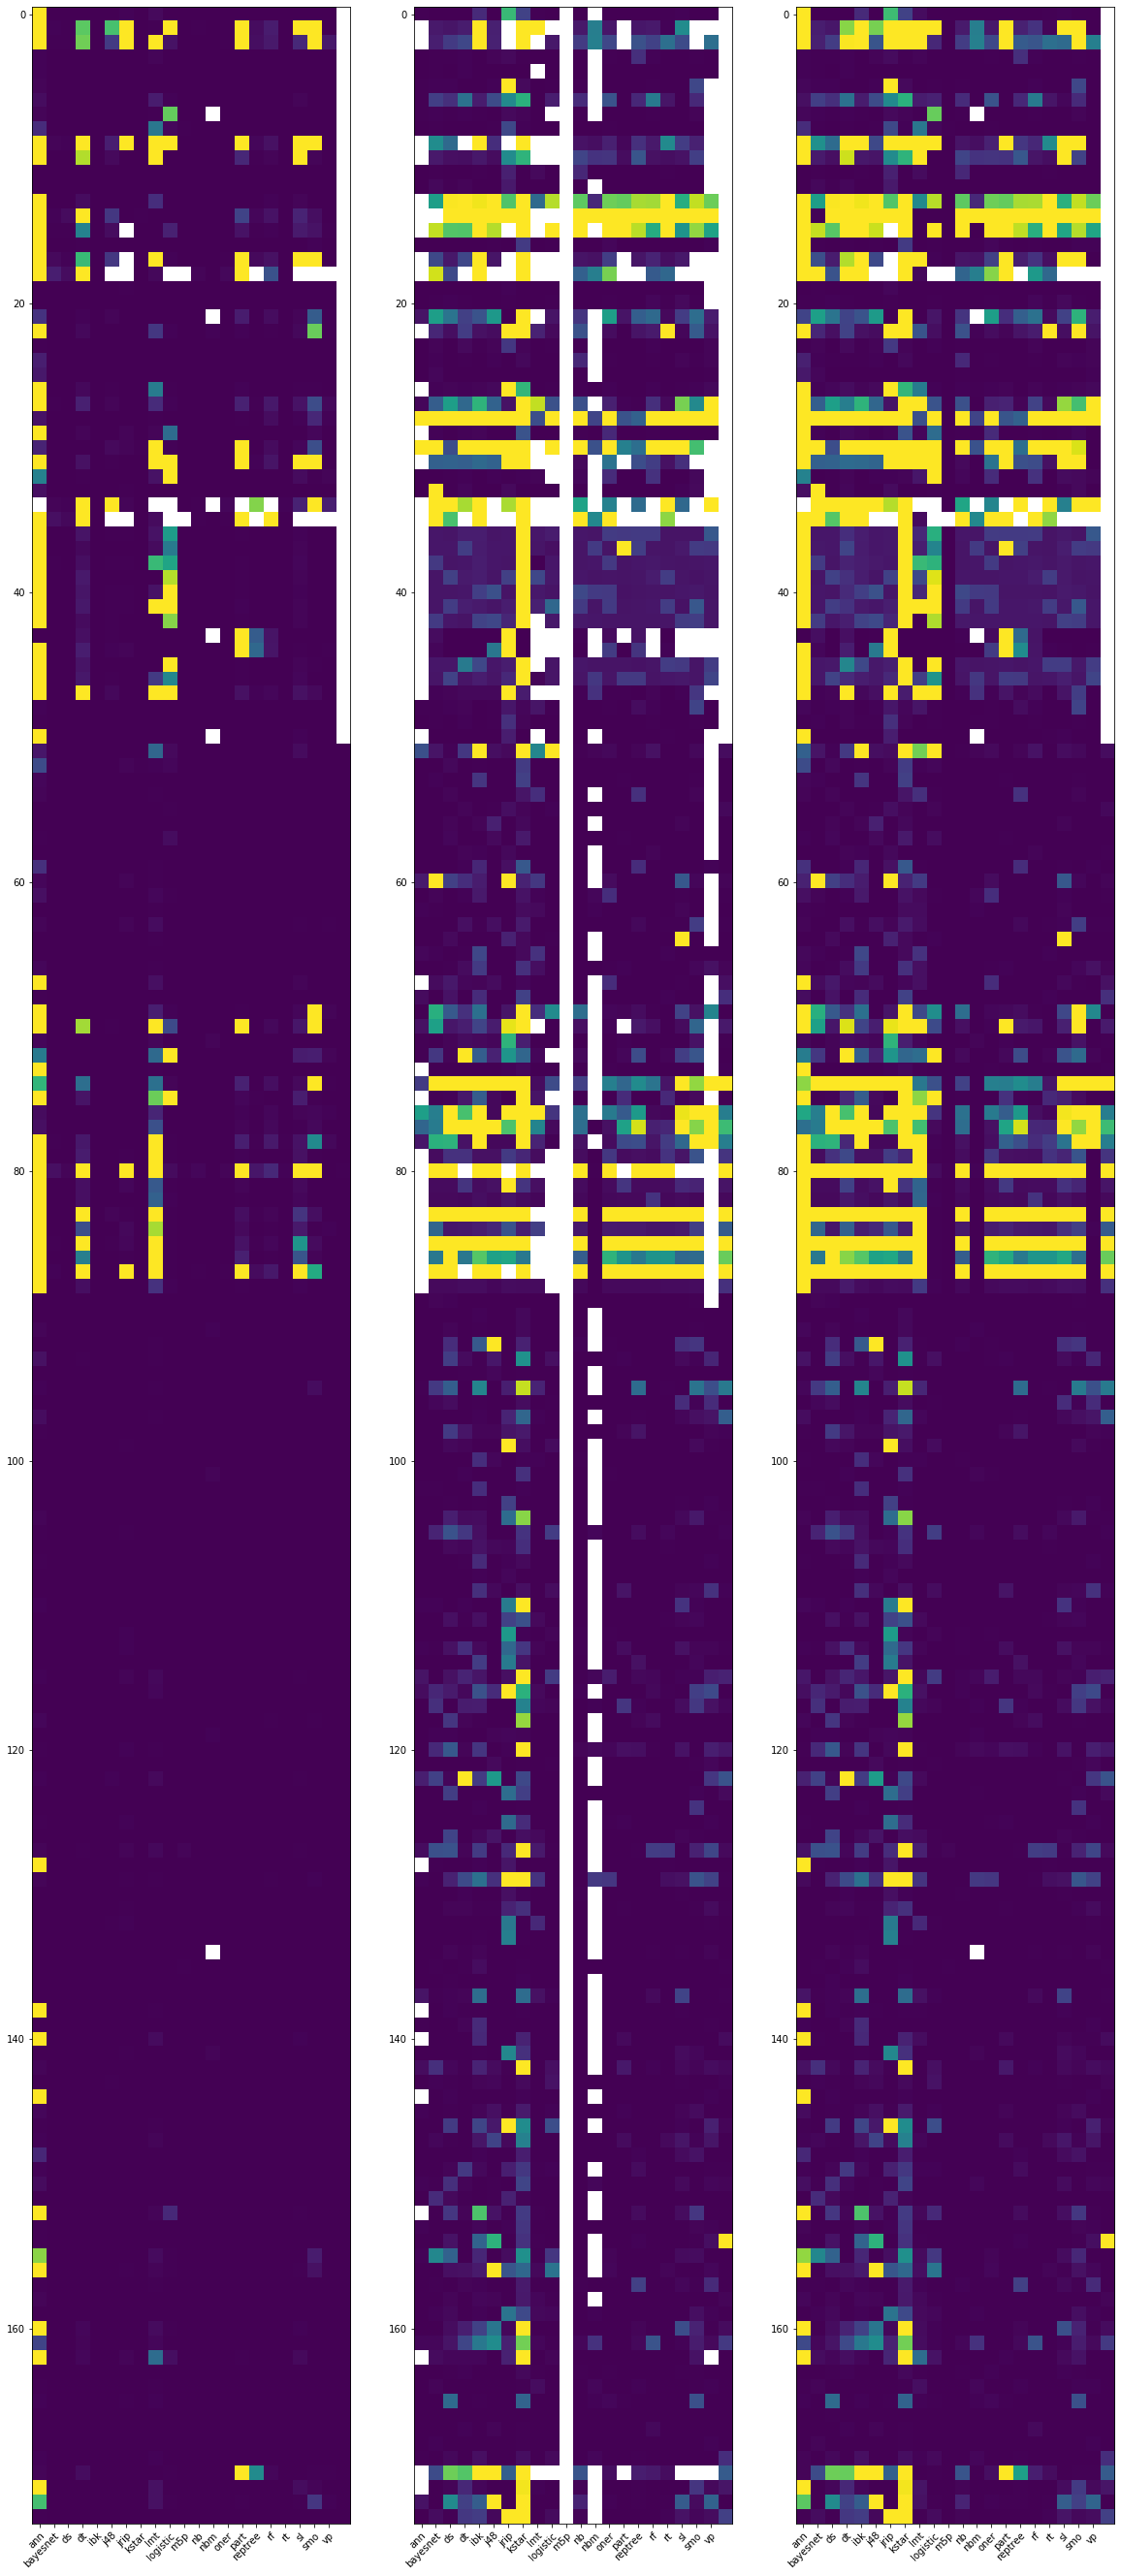

In [9]:
# what is the train and test time of the classifiers on different datasets for 70/30 splits?
timelimit = 60 * 60

fig, ax = plt.subplots(1, 3, figsize=(20,50))
a = ax[0]
im = a.imshow(np.minimum(meanRuntimes7030Train, timelimit), cmap='viridis', vmin=0, vmax=timelimit)
a.set_xticks(np.arange(len(classifiers) - 1))
a.set_xticklabels(classifiers)
plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.savefig("runtime-train.pdf")

a = ax[1]
im = a.imshow(np.minimum(meanRuntimes7030Test, timelimit), cmap='viridis', vmin=0, vmax=timelimit)
a.set_xticks(np.arange(len(classifiers) - 1))
a.set_xticklabels(classifiers)
plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.savefig("runtime-test.pdf")

a = ax[2]
im = a.imshow(np.minimum(meanRuntimes7030Total, timelimit), cmap='viridis', vmin=0, vmax=timelimit)
a.set_xticks(np.arange(len(classifiers) - 1))
a.set_xticklabels(classifiers)
plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.savefig("runtime-total.pdf")

#cbar = fig.colorbar(im)
;

In [15]:
# Analyze the intuitition that one would expect some sort of dominance among algorithms
advTableAvgAbsolute = meanRuntimes7030Total
advTableAvg = np.zeros(advTableAvgAbsolute.shape)
numCases = advTableAvgAbsolute.shape[0]
for i, c1 in enumerate(classifiers):
    #print(c1 + ": " + str(advTableAvgAbsolute[:,i]))
    for j, c2 in enumerate(classifiers):
        if c1 == c2:
            continue
        pairAdvantages = np.where(advTableAvgAbsolute[:,i] <= advTableAvgAbsolute[:,j])[0]
        #print(c1 + "/" + c2 + ": " + str(pairAdvantages))
        dominance = pairAdvantages.size / numCases
        advTableAvg[i][j] = dominance
        if dominance > .85:
            print (c1 + " dominates " + c2 + " in " + str(dominance * 100) + "% of the cases")

In [16]:
# What is the comparison of runtimes of classifiers among all datasets?
# Here, we use the canonical splits based on train sizes instead of 70/30 splits
timeouts = np.linspace(0, 20 * 60, 30 * 60 / 90 + 1)
timeoutIndex = np.where(timeouts == timeout)[0]
print(timeouts)
advTable = np.zeros([len(timeouts), len(classifiers), len(classifiers)])
for t, to in enumerate(timeouts):
    for i, c1 in enumerate(classifiers):
        dataWithClassifierC1 = df.query("classifier == '" + str(c1) + "' and trainpoints > testpoints and traintime + testtime >= " + str(to))
        for j, c2 in enumerate(classifiers):
            if c1 != c2:
                dataWithClassifierC2 = df.query("classifier == '" + str(c2) + "' and trainpoints > testpoints  and traintime + testtime >= " + str(to))
                join = dataWithClassifierC1.merge(dataWithClassifierC2, on=["openmlid", "trainpoints", "seed"])[["classifier_x", "classifier_y", "traintime_x", "testtime_x", "traintime_y", "testtime_y"]]
                #print(c1 + "/" + c2 + ": " + str(len(join)))
                #print(join)
                vals = join.values
                totalRuntimesX = vals[:,2] + vals[:,3]
                totalRuntimesY = vals[:,4] + vals[:,5]
                advTable[t][i][j] = np.where(totalRuntimesX <= totalRuntimesY)[0].size / len(join) if len(join) > 0 else 0

[   0.   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.
  720.  780.  840.  900.  960. 1020. 1080. 1140. 1200.]


In [17]:
# now compute the relative frequency of cases in which classifier 1 is faster than 2
# including training AND test on a 70/30 split
advTableTotal = np.zeros([len(timeouts), len(classifiers), len(classifiers)]) # this is the total advantage on 70/30 splits
for t, to in enumerate(timeouts):
    for i, c1 in enumerate(classifiers):
        dataWithClassifierC1 = table7030[:,i]
        for j, c2 in enumerate(classifiers):
            if c1 != c2:
                dataWithClassifierC2 = table7030[:,j]
                scores = []
                for d, ds in enumerate(datasets[:,0]):
                    #print(c1 + "/" + c2 + " on dataset " + str(d))
                    v1 = dataWithClassifierC1[d]
                    if len(v1) > 0:
                        r1 = np.sum(v1, axis=1)
                        #print("v1: " + str(v1) + ", r1: " + str(r1))
                        r1 = r1[r1 >= to]
                        v2 = dataWithClassifierC2[d]
                        if len(v2) > 0:
                            r2 = np.sum(v2, axis=1)
                            #print("v2: " + str(v2) + ", r2: " + str(r2))
                            r2 = r2[r2 >= to]
                            #print(str(r1) + " vs. " + str(r2))
                            score = 0
                            #for u in r1:
                            #    for v in r2:
                            #        if u <= v:
                            #            score += 1
                            #comps = (len(r1) * len(r2))
                            #scores.append(score / comps if comps > 0 else 0)
                            if np.mean(r1) <= np.mean(r2):
                                score += 1
                            scores.append(score)
                advTableTotal[t][i][j] = np.mean(scores)

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal


Timeout: 0.0(index 0)


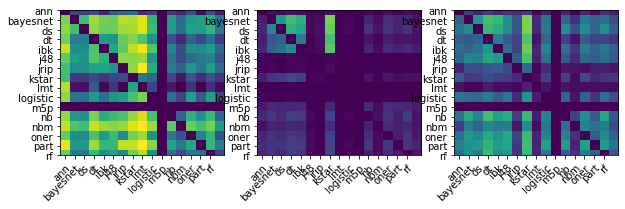

Timeout: 60.0(index 1)


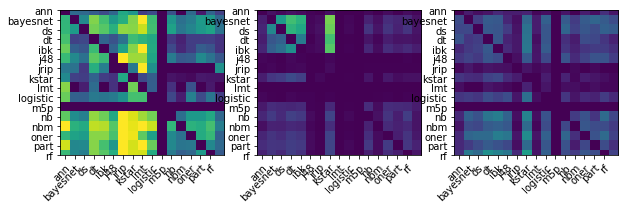

Timeout: 120.0(index 2)


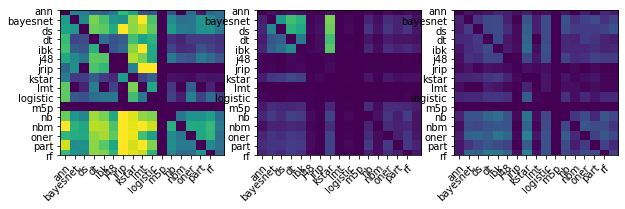

Timeout: 180.0(index 3)


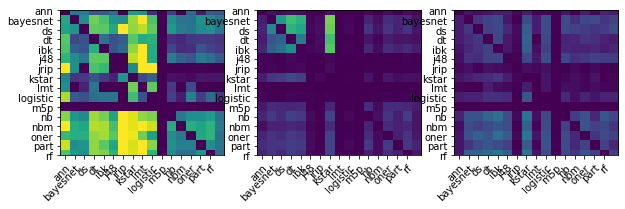

Timeout: 240.0(index 4)


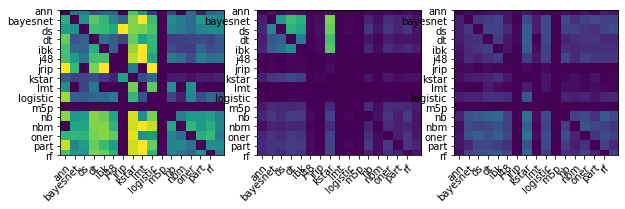

Timeout: 300.0(index 5)


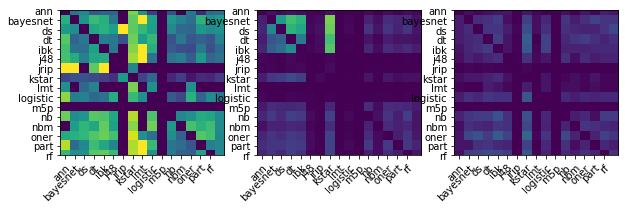

Timeout: 360.0(index 6)


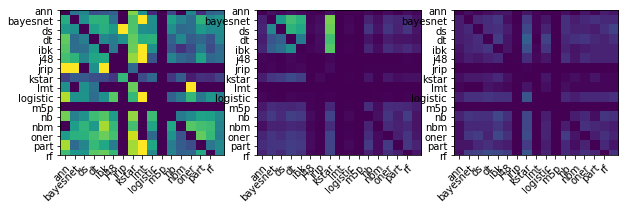

Timeout: 420.0(index 7)


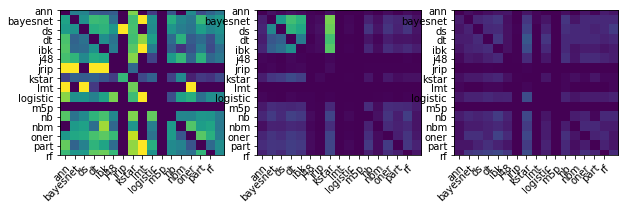

Timeout: 480.0(index 8)


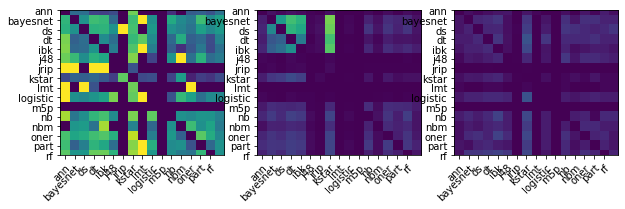

Timeout: 540.0(index 9)


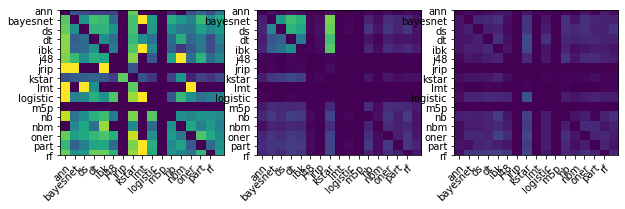

Timeout: 600.0(index 10)


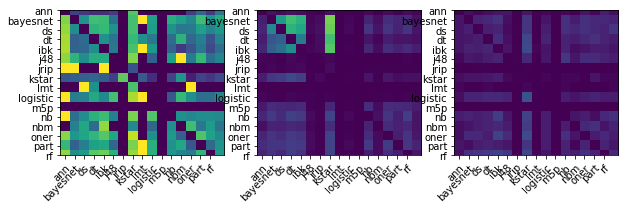

Timeout: 660.0(index 11)


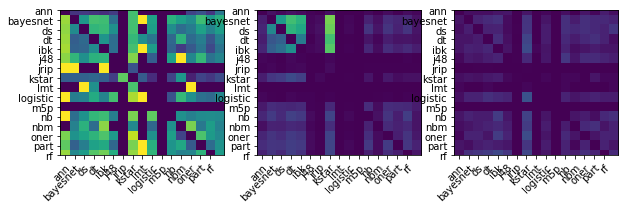

Timeout: 720.0(index 12)


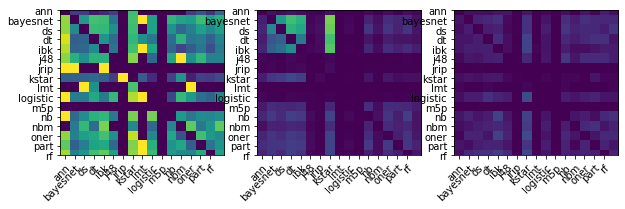

Timeout: 780.0(index 13)


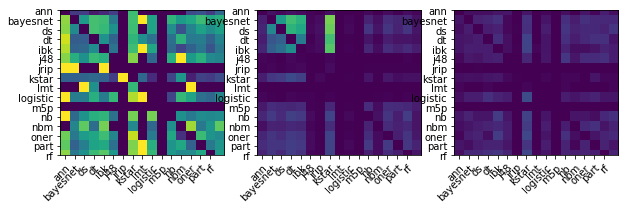

Timeout: 840.0(index 14)


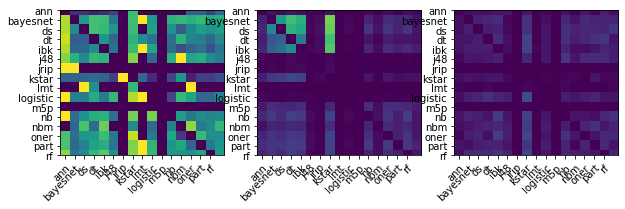

Timeout: 900.0(index 15)


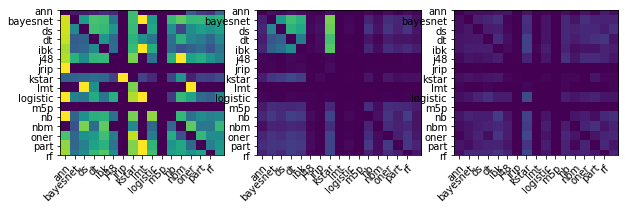

Timeout: 960.0(index 16)


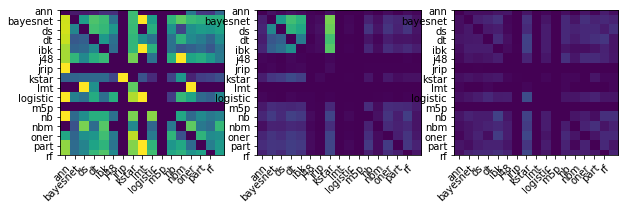

Timeout: 1020.0(index 17)


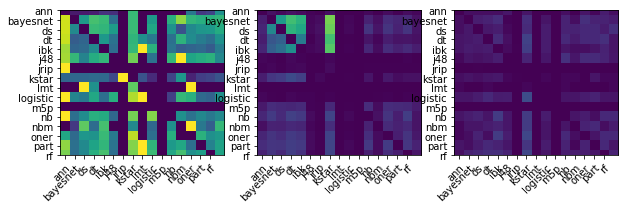

Timeout: 1080.0(index 18)


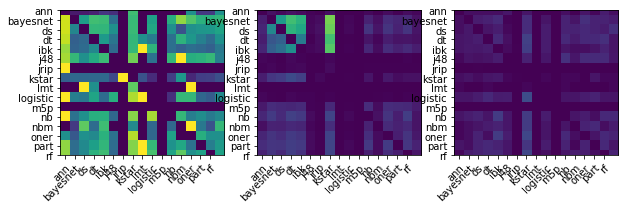

Timeout: 1140.0(index 19)


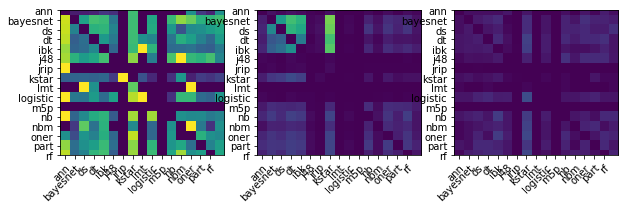

Timeout: 1200.0(index 20)


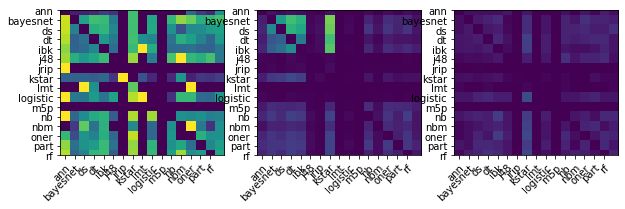

In [18]:
# plot the advantage tables (total and 70/30 split) for different timesouts
for t,to in enumerate(timeouts):
    
    print("Timeout: " + str(to) + "(index " + str(t) + ")")
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3))
    a = ax[0]
    im = a.imshow(advTable[t], cmap='viridis', vmin=0, vmax=1)
    a.set_xticks(np.arange(len(classifiers) - 1))
    a.set_xticklabels(classifiers)
    a.set_yticks(np.arange(len(classifiers) - 1))
    a.set_yticklabels(classifiers)
    plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    a = ax[1]
    im = a.imshow(advTableAvg, cmap='viridis', vmin=0, vmax=1)
    a.set_xticks(np.arange(len(classifiers) - 1))
    a.set_xticklabels(classifiers)
    a.set_yticks(np.arange(len(classifiers) - 1))
    a.set_yticklabels(classifiers)
    plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    a = ax[2]
    im = a.imshow(advTableTotal[t], cmap='viridis', vmin=0, vmax=1)
    a.set_xticks(np.arange(len(classifiers) - 1))
    a.set_xticklabels(classifiers)
    a.set_yticks(np.arange(len(classifiers) - 1))
    a.set_yticklabels(classifiers)
    plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.savefig("rule-heatmaps.pdf")
    plt.show()
    #cbar = fig.colorbar(im)
    ;

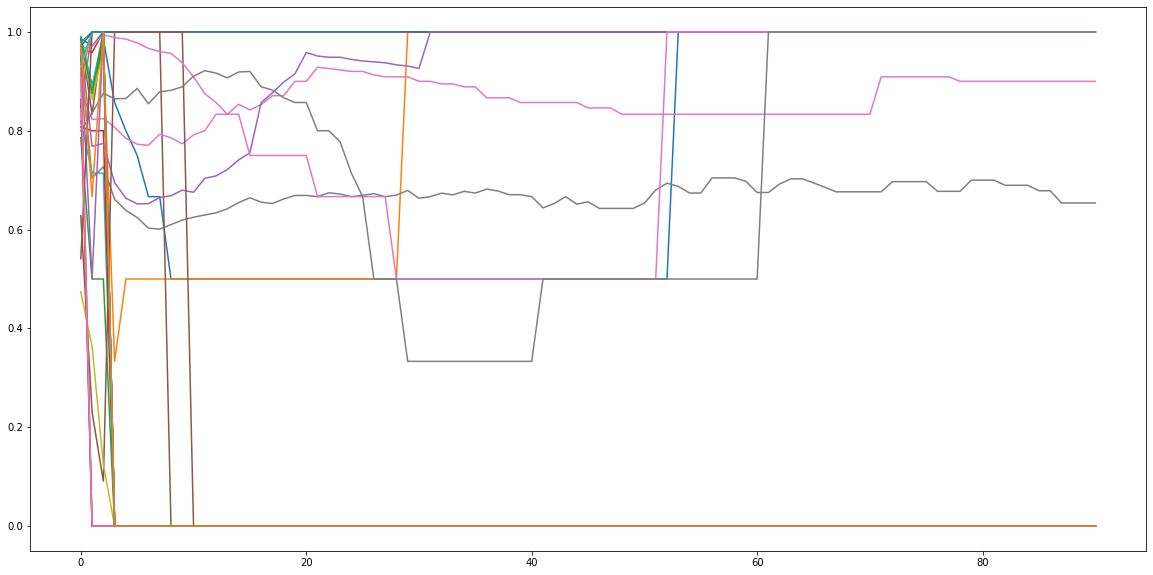

In [321]:
# Observe if any of the rules has at least for one timeout a support of .9
frequent = np.where(np.max(advTableTotal, axis=0) > .8)
plt.figure(figsize=(20,10))
for i,x in enumerate(frequent[0]):
    y = frequent[1][i]
    series = advTableTrain[:,x,y]
    plt.plot(series)
plt.show()

In [356]:
# Is there a simple rule for pairs of the form "runtime of x is always higher than the one of y"?
import itertools
epsilon = .5
priorDominances = (advTableTotal[timeoutIndex] >= 1 - epsilon)[0]

[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False Fal

In [14]:
## POSTERIOR RULES ##



# define feature columns
featureCols = list(idf.columns)
featureCols.remove("traintime")
featureCols.remove("testtime")
featureCols.remove("classifier")

In [330]:
## Second, consider all possible pairs of classifiers
## For each pair, train a binary classifier based on the observed data that will predict the runtime dominance
## i.e. will predict whether c1 runs faster than c2 on a given dataset
models = [[0 for x in range(len(classifiers))] for y in range(len(classifiers))] 
predictabilities = np.zeros([len(classifiers), len(classifiers)])
for i, c1 in enumerate(classifiers):
    dataWithClassifierC1 = idf.query("classifier == '" + str(c1) + "' and traintime >= " + str(timeout))
    for j, c2 in enumerate(classifiers):
        if c1 != c2:
            dataWithClassifierC2 = idf.query("classifier == '" + str(c2) + "' and traintime >= " + str(timeout))
            join = dataWithClassifierC1.merge(dataWithClassifierC2, on=featureCols)
            X = join[featureCols]
            if len(X) > 12:
                targetData = join[["traintime_x", "testtime_x", "traintime_y", "testtime_y"]].values
                y = targetData[:,0] < targetData[:,2]
                c = sk.ensemble.RandomForestClassifier(n_estimators=100)
                scores = sk.model_selection.cross_val_score(c, X, y, cv=10)
                predictabilities[i][j] = np.mean(scores)

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 me

In [332]:
posteriorDominanceDecidability = predictabilities >= .9
overlap = priorDominances * posteriorDominanceDecidability

IndexError: index 15 is out of bounds for axis 0 with size 1

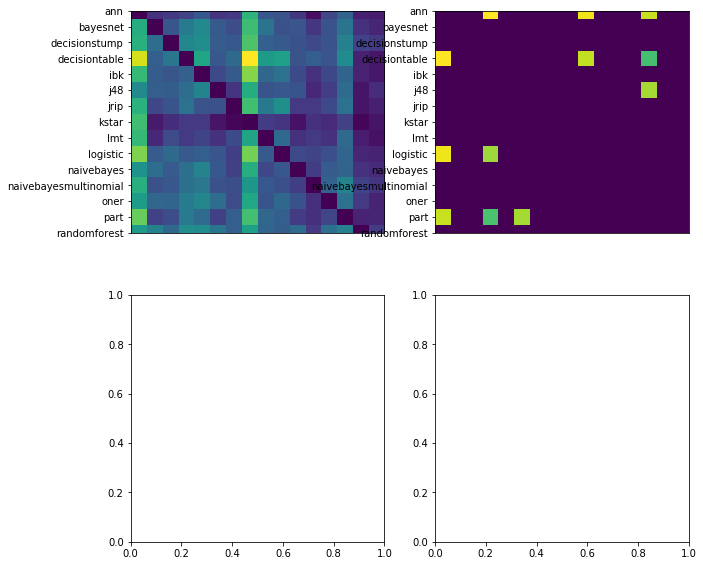

In [343]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
a = ax[0][0]
im = a.imshow(advTableTotal[20], cmap='viridis')
#a.set_xticks(np.arange(len(classifiers) - 1))
#a.set_xticklabels(classifiers)
a.get_xaxis().set_visible(False)
a.set_yticks(np.arange(len(classifiers) - 1))
a.set_yticklabels(classifiers)
plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

a = ax[0][1]
im = a.imshow(predictabilities, cmap='viridis')
a.get_xaxis().set_visible(False)
#a.set_xticks(np.arange(len(classifiers) - 1))
#a.set_xticklabels(classifiers)
a.set_yticks(np.arange(len(classifiers) - 1))
a.set_yticklabels(classifiers)
plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

a = ax[1][0]
im = a.imshow(priorDominances[timeoutIndex], cmap='viridis')
a.set_xticks(np.arange(len(classifiers) - 1))
a.set_xticklabels(classifiers)
a.set_yticks(np.arange(len(classifiers) - 1))
a.set_yticklabels(classifiers)
plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

a = ax[1][1]
im = a.imshow(posteriorDominanceDecidability, cmap='viridis')
a.set_xticks(np.arange(len(classifiers) - 1))
a.set_xticklabels(classifiers)
a.set_yticks(np.arange(len(classifiers) - 1))
a.set_yticklabels(classifiers)
plt.setp(a.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.subplots_adjust(wspace=0.7, hspace=-.45)

plt.savefig("priorvsposteriorrules.pdf")
;

In [22]:
for i, c1 in enumerate(classifiers):
    for j, c2 in enumerate(classifiers):
        p = predictabilities[i][j]
        if p > .9:
            print ("Predictability of " + c1 + " vs " + c2 + " is " + str(p))

Predictability of ann vs randomtree is 0.927647756686799
Predictability of jrip vs naivebayes is 0.9231559482227245
Predictability of jrip vs oner is 0.9420072115384616
Predictability of lmt vs decisionstump is 0.9759358288770054
Predictability of lmt vs ibk is 0.9561976883220407
Predictability of lmt vs j48 is 0.9683456183456184
Predictability of lmt vs naivebayes is 0.9316546762589928
Predictability of lmt vs naivebayesmultinomial is 0.9699736995908825
Predictability of lmt vs randomforest is 0.9863013698630136
Predictability of lmt vs randomtree is 1.0
Predictability of part vs randomtree is 0.9226190476190477
Predictability of randomforest vs naivebayesmultinomial is 0.915891436557931


In [202]:
### Third step, analyze the true positives and false positives one achieves with the given rules
tau1 = .5
tau2 = 1
tau3 = 3
epsilon1 = 0.05
epsilon2 = 0.15
discountExponent = 1

In [203]:
#def getAllExecutionsOnDataset(df, series):
#    return df.query("openmlid == '" + str(series[["openmlid"]][0]) + "' and trainpoints == '" + str(series[["trainpoints"]][0]) + "' and seed == '" + str(series[["seed"]][0]) + "'")



In [204]:
import scipy

In [205]:

## In the following, we want to check whether the prediction about the no-execution of C1 (i) is good
for i, classifier in enumerate(classifiers):
    print("Computing dominances for c1 = " + classifier)
    #priorA = advTable[:,i]
    #posteriorA = predictabilities[:,i]
    #priorB = advTable[i,:]
    #posteriorB = predictabilities[i,:]
    
    # compute the prior dominance evidences
    #relevantPriorA = priorA[priorA >= 1 - epsilon1]
    #relevantPriorB = priorB[priorB >= 1 - epsilon1]
    
    # now consider different random splits of the knowledge available to train the posterior rules
    for cv in range(10):
        
        print ("Fold " + str(cv))
        
        # now consider an application of the knowledge to a classifier trained on a concrete subset
        split = sk.model_selection.train_test_split(idf)
        train = split[0]
        valid = split[1]
        
        # compute, for the testset, all datasets for which information on classifier c1 is available
        trainDataWithClassifierC1 = train.query("classifier == '" + classifier + "'")
        validDataWithClassifierC1 = valid.query("classifier == '" + classifier + "'")
        
        # gather the predictions for each classifier
        P = np.zeros((len(validDataWithClassifierC1), len(classifiers)))
        Q = np.zeros((len(validDataWithClassifierC1), len(classifiers)))
        for j, c2 in enumerate(classifiers):
            print("Comparing with " + c2)
            if c2 != classifier:
                
                # train prediction model for the C1/C2 pair based on the train fold
                # the classifier c will return TRUE if classifier c2 dominates classifier c1
                dataWithClassifierC2 = train.query("classifier == '" + c2 + "'")
                join = trainDataWithClassifierC1.merge(dataWithClassifierC2, on=featureCols)
                X = join[featureCols]
                targetData = join[["traintime_x", "testtime_x", "traintime_y", "testtime_y"]].values
                y = targetData[:,0] > targetData[:,2]
                c = sk.ensemble.RandomForestClassifier(n_estimators=100)
                c.fit(X, y)

                # now iterate, for this C1/C2 combination, over all datasets in the test fold,
                # and compute the probability that C1 will timeout based on posterior dominance
                #
                # to this end, it is checked whether C2 timed out on the data. If not, no dominance
                # can be concluded. If C2 timed out, predict whether C2 will dominate C1.
                # If yes, multiply the dominance probability with the predictability of this classifier.
                validDataWithClassifierC2 = valid.query("classifier == '" + c2 + "'")
                k = 0
                for dummyVar, ds in validDataWithClassifierC1.iterrows():
                    
                    # first get runtime information of c2 for this data
                    caseMatch = validDataWithClassifierC2.query("openmlid == '" + str(ds["openmlid"]) + "' and trainpoints == '" + str(ds["trainpoints"]) + "' and seed == '" + str(ds["seed"]) + "'")
                    if len(caseMatch) > 0:
                        
                        # now determine whether c2 has timed out. In that case, consider the predicted probability of dominance
                        runtimesOfC2OnThisCase = validDataWithClassifierC2.query("openmlid == '" + str(ds["openmlid"]) + "' and trainpoints == '" + str(ds["trainpoints"]) + "'")[["traintime"]].values
                        if scipy.stats.trim_mean(runtimesOfC2OnThisCase, 0.1) >= timeout:
                            prediction = c.predict_proba([ds[featureCols].values])
                            P[k][j] = (prediction[:,1] * (predictabilities[j][i]**discountExponent))[0] ## ATTENTION: predictabilities must be invoked with j/i here, because lines dominate columns
                            if P[k][j] > 0.5:
                                print(c2 + " has timeouted on " + str(k) + ", and the prediction for dominance over " + classifier + " is " + str(prediction[:,1]) + ", and the confidence in this prediction is " + str(predictabilities[j][i]))
                            Q[k][j] = advTableTrain[j][i]**discountExponent # define the (discounted) prior advantage
                    k += 1
                
        # At this point, we have the prior and posterior values for all other classifiers
        # Now compute the belief that classifier c1 will time out as the product of (1-x) on all datasets
        k = 0
        truePositives = 0
        falsePositives = 0
        for dummyVar, ds in validDataWithClassifierC1.iterrows():
            print ("Now considering " + str(k))
            secondTerm = 1
            for j, c2 in enumerate(classifiers):
                if P[k][j] > 0:
                    secondTerm *= (1 - P[k][j])
                    print("\tDecrease counter probability by posterior dominance of " + c2 + ": " + str(P[k][j]))
                if Q[k][j] > 0:
                    secondTerm *= (1 - Q[k][j])
                    print("\tDecrease counter probability by prior dominance of " + c2 + ": " + str(Q[k][j]))
                if secondTerm == 0:
                    break
            runtimeOfC1OnThisDatum = ds[["traintime"]].values[0]
            didTimeout = runtimeOfC1OnThisDatum >= timeout
            toBelief = 1 - secondTerm
            reject = toBelief > .85
            if reject:
                print("Probability to timeout on ds " + str(k) + " is: " + str(toBelief) + ". Did it time out? " + str(didTimeout) + ". Runtime was " + str(runtimeOfC1OnThisDatum))
                if didTimeout:
                    truePositives += 1
                else:
                    print(str(ds[["openmlid"]][0]) + ", " + str(ds[["trainpoints"]][0]) + ", " + str(ds[["seed"]][0]))
                    falsePositives += 1
            k += 1
        print("TP: " + str(truePositives))
        print("FP: " + str(falsePositives))

Computing dominances for c1 = ann
Fold 0
Comparing with ann
Comparing with bayesnet
bayesnet has timeouted on 334, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.74344301382928
Comparing with decisionstump
Comparing with decisiontable
Comparing with ibk
Comparing with j48
j48 has timeouted on 1613, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.6226415094339622
Comparing with jrip
Comparing with kstar
Comparing with lmt
lmt has timeouted on 839, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.6063883299798792
lmt has timeouted on 1348, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.6063883299798792
Comparing with logistic
logistic has timeouted on 850, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.693284873295166
logistic has timeouted on 1120, and the pr

Now considering 1072
Now considering 1073
Now considering 1074
Now considering 1075
Now considering 1076
Now considering 1077
Now considering 1078
Now considering 1079
Now considering 1080
Now considering 1081
Now considering 1082
Now considering 1083
Now considering 1084
Now considering 1085
Now considering 1086
Now considering 1087
Now considering 1088
Now considering 1089
Now considering 1090
Now considering 1091
Now considering 1092
Now considering 1093
Now considering 1094
Now considering 1095
Now considering 1096
Now considering 1097
Now considering 1098
Now considering 1099
Now considering 1100
Now considering 1101
Now considering 1102
Now considering 1103
Now considering 1104
Now considering 1105
Now considering 1106
Now considering 1107
Now considering 1108
Now considering 1109
Now considering 1110
Now considering 1111
Now considering 1112
Now considering 1113
Now considering 1114
Now considering 1115
Now considering 1116
Now considering 1117
Now considering 1118
Now consideri

Comparing with decisionstump
decisionstump has timeouted on 22, and the prediction for dominance over ann is [0.89], and the confidence in this prediction is 0.6811602866483469
decisionstump has timeouted on 1062, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.6811602866483469
decisionstump has timeouted on 1448, and the prediction for dominance over ann is [0.98], and the confidence in this prediction is 0.6811602866483469
Comparing with decisiontable
decisiontable has timeouted on 614, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.6258877840909091
decisiontable has timeouted on 1178, and the prediction for dominance over ann is [1.], and the confidence in this prediction is 0.6258877840909091
Comparing with ibk
Comparing with j48
Comparing with jrip
Comparing with kstar
Comparing with lmt
Comparing with logistic
Comparing with naivebayes
Comparing with naivebayesmultinomial
Comparing with o

Now considering 652
Now considering 653
Now considering 654
Now considering 655
Now considering 656
Now considering 657
	Decrease counter probability by posterior dominance of logistic: 0.04852994113066162
	Decrease counter probability by prior dominance of logistic: 0.9512113617376775
Probability to timeout on ds 657 is: 0.9535790714803931. Did it time out? False. Runtime was 15
4552, 75, 9
Now considering 658
Now considering 659
Now considering 660
Now considering 661
Now considering 662
Now considering 663
Now considering 664
Now considering 665
Now considering 666
Now considering 667
Now considering 668
Now considering 669
Now considering 670
Now considering 671
Now considering 672
Now considering 673
Now considering 674
Now considering 675
Now considering 676
Now considering 677
Now considering 678
Now considering 679
	Decrease counter probability by posterior dominance of part: 0.6971483252559626
	Decrease counter probability by prior dominance of part: 0.972852195285443
Probabil

Now considering 1123
Now considering 1124
Now considering 1125
Now considering 1126
Now considering 1127
Now considering 1128
Now considering 1129
Now considering 1130
Now considering 1131
Now considering 1132
Now considering 1133
Now considering 1134
Now considering 1135
Now considering 1136
Now considering 1137
Now considering 1138
Now considering 1139
Now considering 1140
Now considering 1141
Now considering 1142
Now considering 1143
Now considering 1144
Now considering 1145
Now considering 1146
Now considering 1147
Now considering 1148
Now considering 1149
Now considering 1150
Now considering 1151
Now considering 1152
Now considering 1153
Now considering 1154
Now considering 1155
Now considering 1156
Now considering 1157
Now considering 1158
Now considering 1159
Now considering 1160
Now considering 1161
Now considering 1162
Now considering 1163
Now considering 1164
Now considering 1165
Now considering 1166
Now considering 1167
Now considering 1168
Now considering 1169
Now consideri

Comparing with decisionstump


KeyboardInterrupt: 

In [195]:
idf.query("openmlid == 181 and trainpoints == 150 and (classifier == 'naivebayesmultinomial' or classifier == 'ann')")

,openmlid,datapoints_x,trainpoints,testpoints,seed,classifier,traintime,testtime,datapoints_y,numinstances,...,accvarianceabs2,accvarianceabs3,accvarianceabs4,accvarianceabs5,accvarianceabs6,accvarianceabs7,accvarianceabs8,accvarianceabs9,accvarianceabs10,totalvariance
31431,181,1484,150,1334,0,ann,2,0.0,150,150,...,0.038763,0.052232,0.064321,0.073735,0.079414,0.081413,0.083080,0.083080,0.083080,0.083080
31433,181,1484,150,1334,0,naivebayesmultinomial,1,0.0,150,150,...,0.038763,0.052232,0.064321,0.073735,0.079414,0.081413,0.083080,0.083080,0.083080,0.083080
31474,181,1484,150,1334,1,ann,1,0.0,150,150,...,0.038846,0.052237,0.064310,0.073724,0.079469,0.081465,0.081465,0.081465,0.081465,0.081465
31475,181,1484,150,1334,1,naivebayesmultinomial,1,1.0,150,150,...,0.038846,0.052237,0.064310,0.073724,0.079469,0.081465,0.081465,0.081465,0.081465,0.081465
31674,181,1484,150,1334,3,ann,1,0.0,150,150,...,0.039263,0.052888,0.064960,0.072790,0.078640,0.080590,0.080590,0.080590,0.080590,0.080590
31675,181,1484,150,1334,3,naivebayesmultinomial,1,0.0,150,150,...,0.039263,0.052888,0.064960,0.072790,0.078640,0.080590,0.080590,0.080590,0.080590,0.080590
31740,181,1484,150,1334,4,ann,4,165.0,150,150,...,0.039183,0.053072,0.065145,0.072975,0.078848,0.080801,0.082468,0.082468,0.082468,0.082468
31742,181,1484,150,1334,4,naivebayesmultinomial,1,0.0,150,150,...,0.039183,0.053072,0.065145,0.072975,0.078848,0.080801,0.082468,0.082468,0.082468,0.082468
31909,181,1484,150,1334,6,ann,2,0.0,150,150,...,0.038946,0.052596,0.064666,0.072495,0.078357,0.080299,0.080299,0.080299,0.080299,0.080299
31911,181,1484,150,1334,6,naivebayesmultinomial,1,10.0,150,150,...,0.038946,0.052596,0.064666,0.072495,0.078357,0.080299,0.080299,0.080299,0.080299,0.080299
